In [1]:
import fitsio
from astropy.io import fits
import matplotlib.pyplot as plt
import astropy.table as t
# importing all modules
import os
import fitsio
import matplotlib.pyplot as plt
import glob
from astropy.io import fits
import numpy as np
import astropy.table as t
import subprocess
import json 
import scipy.optimize as so
from scipy.integrate import odeint
import numpy.ma as ma
from scipy.stats import linregress
import pandas as pd
from scipy.stats import binned_statistic as bn
import pickle

In [2]:
# checking which tiles have truth tables
trutab=t.Table.read('/global/cfs/cdirs/desi/sv/vi/TruthTables/Fuji/ELG/220505_ELG_SV1_blanc_and_Fuji_v1.csv')
trutab2=t.Table.read('/global/cfs/cdirs/desi/sv/vi/TruthTables/Fuji/LRG/220505_LRG_SV1_blanc_and_Fuji_v1.csv')
print(np.unique(trutab2['TILEID']))
print(np.unique(trutab['TILEID']))

TILEID
------
 80605
 80609
TILEID
------
 80606
 80608
 80610


In [6]:
# reading each fits file in emfit output
for filename in emlist:
    emread1= fitsio.FITS(filename)
print(emread1[1].read_header())


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / 8-bit bytes
NAXIS   =                    2 / 2-dimensional binary table
NAXIS1  =                  345 / width of table in bytes
NAXIS2  =                  500 / number of rows in table
PCOUNT  =                    0 / size of special data area
GCOUNT  =                    1 / one data group (required keyword)
TFIELDS =                   80 / number of fields in each row
TTYPE1  = 'TARGETID'           / label for field   1
TFORM1  = 'K'                  / data format of field: 8-byte INTEGER
TTYPE2  = 'Z'                  / label for field   2
TFORM2  = 'D'                  / data format of field: 8-byte DOUBLE
TTYPE3  = 'ZWARN'              / label for field   3
TFORM3  = 'K'                  / data format of field: 8-byte INTEGER
TTYPE4  = 'SPECTYPE'           / label for field   4
TFORM4  = '6A'                 / data format of field: ASCII Character
TTYPE5  = 'DELTACHI2'          / label for f

In [4]:
def read_tile_catalog(tile_string):
    # Read galaxy catalog of a tile including line fit information of all objects
    # input: string with the ID of the tile, e.g. "80605"
    # returns: structured array with catalog of all objects in that tile
    
    emlist = glob.glob('/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/'+tile_string+'/*/emline*.fits')
    emtable = t.Table()
    for filename in emlist:
        #emread2=fits.open(filename)
        dumtable=t.Table.read(filename)
        dumtable['RRFN']=dumtable.meta['RRFN']
        dumtable['FN']=filename
        dumtable['COADDFN']=dumtable.meta['COADDFN']
        emtable=t.vstack([dumtable,emtable])
    return emtable

def filter_galaxies(catalog):
    # Filter catalog to only include galaxy targets, return the filtered catalog
    return catalog[catalog['SPECTYPE']=='GALAXY']

def filter_good_fits(catalog, deltachi2=40):
    # Filter catalog to only include targets with no ZWARN flag and good deltachi2
    
    good = (catalog['ZWARN'] == 0) & (catalog['DELTACHI2']>deltachi2)
    return catalog[good]

def calculate_oii_oiii_matrix(catalog, oIIlimit=-3, oIIIlimit=-3):
    
    # return normalized matrix of whether OII and OIII fluxes are or are not compatible with physical fit
    
    matrix = np.zeros(4)
    # ordered as 'OII good, OIII good', 'good, bad', 'bad, good', 'bad, bad' where bad means the significance of the respective flux is smaller than the limit passed to the function
    
    select = (catalog['OII_FLUX']*catalog['OII_FLUX_IVAR']**0.5 > oIIlimit) & (catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5 > oIIIlimit)
    matrix[0] = np.sum(select)
    
    select = (catalog['OII_FLUX']*catalog['OII_FLUX_IVAR']**0.5 > oIIlimit) & (catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5 <= oIIIlimit)
    matrix[1] = np.sum(select)
    
    select = (catalog['OII_FLUX']*catalog['OII_FLUX_IVAR']**0.5 <= oIIlimit) & (catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5 > oIIIlimit)
    matrix[2] = np.sum(select)
    
    select = (catalog['OII_FLUX']*catalog['OII_FLUX_IVAR']**0.5 <= oIIlimit) & (catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5 <= oIIIlimit)
    matrix[3] = np.sum(select)
    
    return matrix/np.sum(matrix)


def plot_matrices(matrices):
    
    matrices = np.array(matrices)
    
    # plt.hist(matrices[:,0], label="good OII & OIII",color='blue') hidden because we expect it to be -> 1
    plt.hist(matrices[:,1], label="good OII, bad OIII",bins=(np.linspace(0,0.1,100)),alpha=0.5)
    plt.hist(matrices[:,2], label="bad OII, good OIII",bins=(np.linspace(0,0.1,100)),alpha=0.5)
    plt.hist(matrices[:,3], label="bad OII & OIII",bins=(np.linspace(0,0.1,100)),alpha=0.5)
    plt.legend()
    plt.xlabel('fraction of galaxies')

#def plot_matrices(catalog):
#    
#    matrices = np.array(matrices)
#    plt.scatter()


In [5]:
#tiles=["80653","80654","80655","80656","80657","80658","80659","80660","80661","80662","80663","80664","80665","80666","80669","80670","80673","80674","80675","80676","80677","80678","80679","80680","80681","80682","80683","80684","80685","80686","80687","80688","80689","80690","80691","80692","80693","80694","80695","80696","80697","80698","80699","80700","80701","80702","80703","80705","80706","80707","80708","80709","80710","80711","80712","80715","80718","80719","80720","80721","80722","80724","80726","80728","80729","80730","80731","80732","80733","80734","80735","80736","80737","80738","80740","80741","80742","80782","80783","80784","80785","80786","80787","80788","80789","80790","80856","80857","80858","80859","80860","80861","80862","80863","80865","80866","80867","80869","80870","80871","80872","80873","80875","80876","80879","80882","80885","80886","80887","80888","80889","80890","80891","80892","80893","80894","80895","80896","80897","80898","80899","80900","80901","80902","80938","80944","80949","80950","80951","80952","80954","80955","80956","80958","80959","80960","80962","80963","80966","80968","80970","80971","80972","80974","80975","81000","81001","81002","81003","81004","81005","81006","81007","81008","81009","81010","81011","81012","81013","81014","81015","81022","81056","81057","81058","81059","81060","81061","81062","81063","81064","81065","81066","81067","81068","81069","81072","81073","81074","81075","81088","81097","81098","81099","81100","81101","81102","81103","81104","81105","81106","81107","81108","81109","81110","81111","81112","81113","81114","81115"]
tiles=['81115'] # if you want to test a particular file

81115


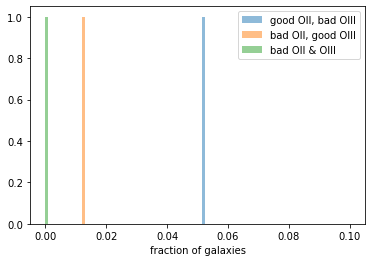

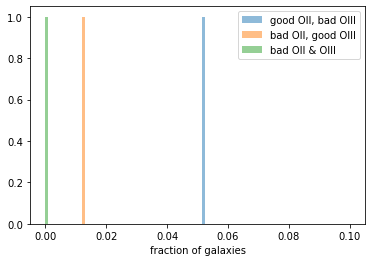

In [6]:

matrices = []
matrices_good=[]
for tile in tiles:
    print(tile)
    catalog = read_tile_catalog(tile)
    # filenames_all.append(filenames)
#    catalog = filter_galaxies(catalog)
    matrices.append(calculate_oii_oiii_matrix(catalog))
    #plot_oiioiiicorrelation(catalog)
#    catalog = filter_good_fits(catalog)
    matrices_good.append(calculate_oii_oiii_matrix(catalog))
    
plot_matrices(matrices)
plt.figure()
plot_matrices(matrices_good)

catalog

plt.imshow([[matricesdum[:,1],matricesdum[:,2]],[matricesgooddum[:,1],matricesgooddum[:,2]]])
plt.colorbar()

In [8]:
# catalog=t.Table(catalog,masked=True)
problematic = (catalog['Z']>0.102)&(catalog['Z']<0.107)&(catalog['OIII_FLUX']*catalog['OIII_FLUX_IVAR']**0.5<-2)
filenames=catalog['FN']
print(filenames[problematic])
print(len(filenames[problematic]))
print(catalog[problematic]['TARGETID'])
print(catalog[problematic]['SPECTYPE'])
print(catalog[problematic]['OBJTYPE'])
print(catalog[problematic]['OII_FLUX']*catalog[problematic]['OII_FLUX_IVAR']**0.5)

                                                    FN                                                    
----------------------------------------------------------------------------------------------------------
/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/emline-8-81115-thru20210513.fits
/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/emline-2-81115-thru20210513.fits
/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/emline-2-81115-thru20210513.fits
/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/emline-3-81115-thru20210513.fits
/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/emline-3-81115-thru20210513.fits
/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/emline-3-81115-thru20210513.fits
/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/emline-3-81115-thru20210513.fits
/global/cfs/cdirs/desi/spectro/redux/

In [41]:
outdict={}

for fn in np.unique(catalog[problematic]['COADDFN']):
    entries=catalog[problematic][catalog[problematic]['COADDFN']==fn]
    fnrr=entries['RRFN'][0]
    rrf=fitsio.FITS(fnrr)
    fobj=fitsio.FITS(fn)
    fm=fobj['FIBERMAP']
    tids=fm['TARGETID'][:]
    for entry in entries:
        if entry['TARGETID'] in tids:
            index=(fm['TARGETID'][:]==entry['TARGETID']).nonzero()[0]
            print(index, entry['TARGETID'])
            outdict[entry['TARGETID']]={'wave':[],'flux':[],'ivar':[],'mask':[],'redshift':rrf['REDSHIFTS']['Z'][index],'petal':fn.split('/')[-1].split('-')[1],'tile':fn.split('/')[-1].split('-')[2]}            
            for color in 'BRZ':
                outdict[entry['TARGETID']]['wave'].append(fobj[f'{color}_WAVELENGTH'][:])
                outdict[entry['TARGETID']]['flux'].append(fobj[f'{color}_FLUX'][index:index+1,:][0])
                outdict[entry['TARGETID']]['ivar'].append(fobj[f'{color}_IVAR'][index:index+1,:][0])
                outdict[entry['TARGETID']]['mask'].append(fobj[f'{color}_MASK'][index:index+1,:][0])


[128] -407199501
[476] 39633441318243200
[100] 39633443889350550
[105] -407200677
[121] -407200717
[146] 39633443889352836
[157] 39633448972846134
[174] 39633446443680962
[183] -407200512
[326] -407200415
[403] 39633438759718709
[492] 39633433483281984


outdict

a=fitsio.FITS(fn)
print(a)

In [18]:
a[1]['DESI_TARGET'].read()
from desitarget.targets import desi_mask, bgs_mask, mws_mask
print(desi_mask)
#1 bit-ELG

desi_mask:
  - [LRG,              0, "LRG", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'MORE_ZGOOD': 2, 'MORE_ZWARN': 2, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0}, 'numobs': 2}]
  - [ELG,              1, "ELG", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3000, 'MORE_ZGOOD': 2, 'MORE_ZWARN': 2, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0}, 'numobs': 2}]
  - [QSO,              2, "QSO", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3400, 'MORE_ZGOOD': 3350, 'MORE_ZWARN': 3300, 'MORE_MIDZQSO': 100, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0}, 'numobs': 4}]
  - [QSO_HIZ,          4, "QSO selected using high-redshift Random Forest (informational bit)", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 0, 'DONE': 0, 'OBS': 0, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0, 'MORE_ZWARN': 0, 'MORE_ZGOOD': 0}, 'numobs': -1}]
  - [ELG_LOP,          5, "ELG at standard (ELG) priority", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3100, 'MORE_ZGOOD': 2,

[bin(i) for i in a[1]['DESI_TARGET'].read()]
a[1]['DESI_TARGET'].read()&desi_mask['LRG_NORTH']

/tmp/ipykernel_38098/1414591690.py:8: RuntimeWarning: divide by zero encountered in power
  ax.plot(w[m==0],i[m==0]**(-0.5),color='r',label='sigma_flux' if j==0 else '')
/tmp/ipykernel_38098/1414591690.py:8: RuntimeWarning: divide by zero encountered in power
  ax.plot(w[m==0],i[m==0]**(-0.5),color='r',label='sigma_flux' if j==0 else '')
/tmp/ipykernel_38098/1414591690.py:8: RuntimeWarning: divide by zero encountered in power
  ax.plot(w[m==0],i[m==0]**(-0.5),color='r',label='sigma_flux' if j==0 else '')
/tmp/ipykernel_38098/1414591690.py:8: RuntimeWarning: divide by zero encountered in power
  ax.plot(w[m==0],i[m==0]**(-0.5),color='r',label='sigma_flux' if j==0 else '')
/tmp/ipykernel_38098/1414591690.py:8: RuntimeWarning: divide by zero encountered in power
  ax.plot(w[m==0],i[m==0]**(-0.5),color='r',label='sigma_flux' if j==0 else '')


6


/tmp/ipykernel_38098/1414591690.py:8: RuntimeWarning: divide by zero encountered in power
  ax.plot(w[m==0],i[m==0]**(-0.5),color='r',label='sigma_flux' if j==0 else '')
/tmp/ipykernel_38098/1414591690.py:8: RuntimeWarning: divide by zero encountered in power
  ax.plot(w[m==0],i[m==0]**(-0.5),color='r',label='sigma_flux' if j==0 else '')
/tmp/ipykernel_38098/1414591690.py:8: RuntimeWarning: divide by zero encountered in power
  ax.plot(w[m==0],i[m==0]**(-0.5),color='r',label='sigma_flux' if j==0 else '')
/tmp/ipykernel_38098/1414591690.py:8: RuntimeWarning: divide by zero encountered in power
  ax.plot(w[m==0],i[m==0]**(-0.5),color='r',label='sigma_flux' if j==0 else '')


12


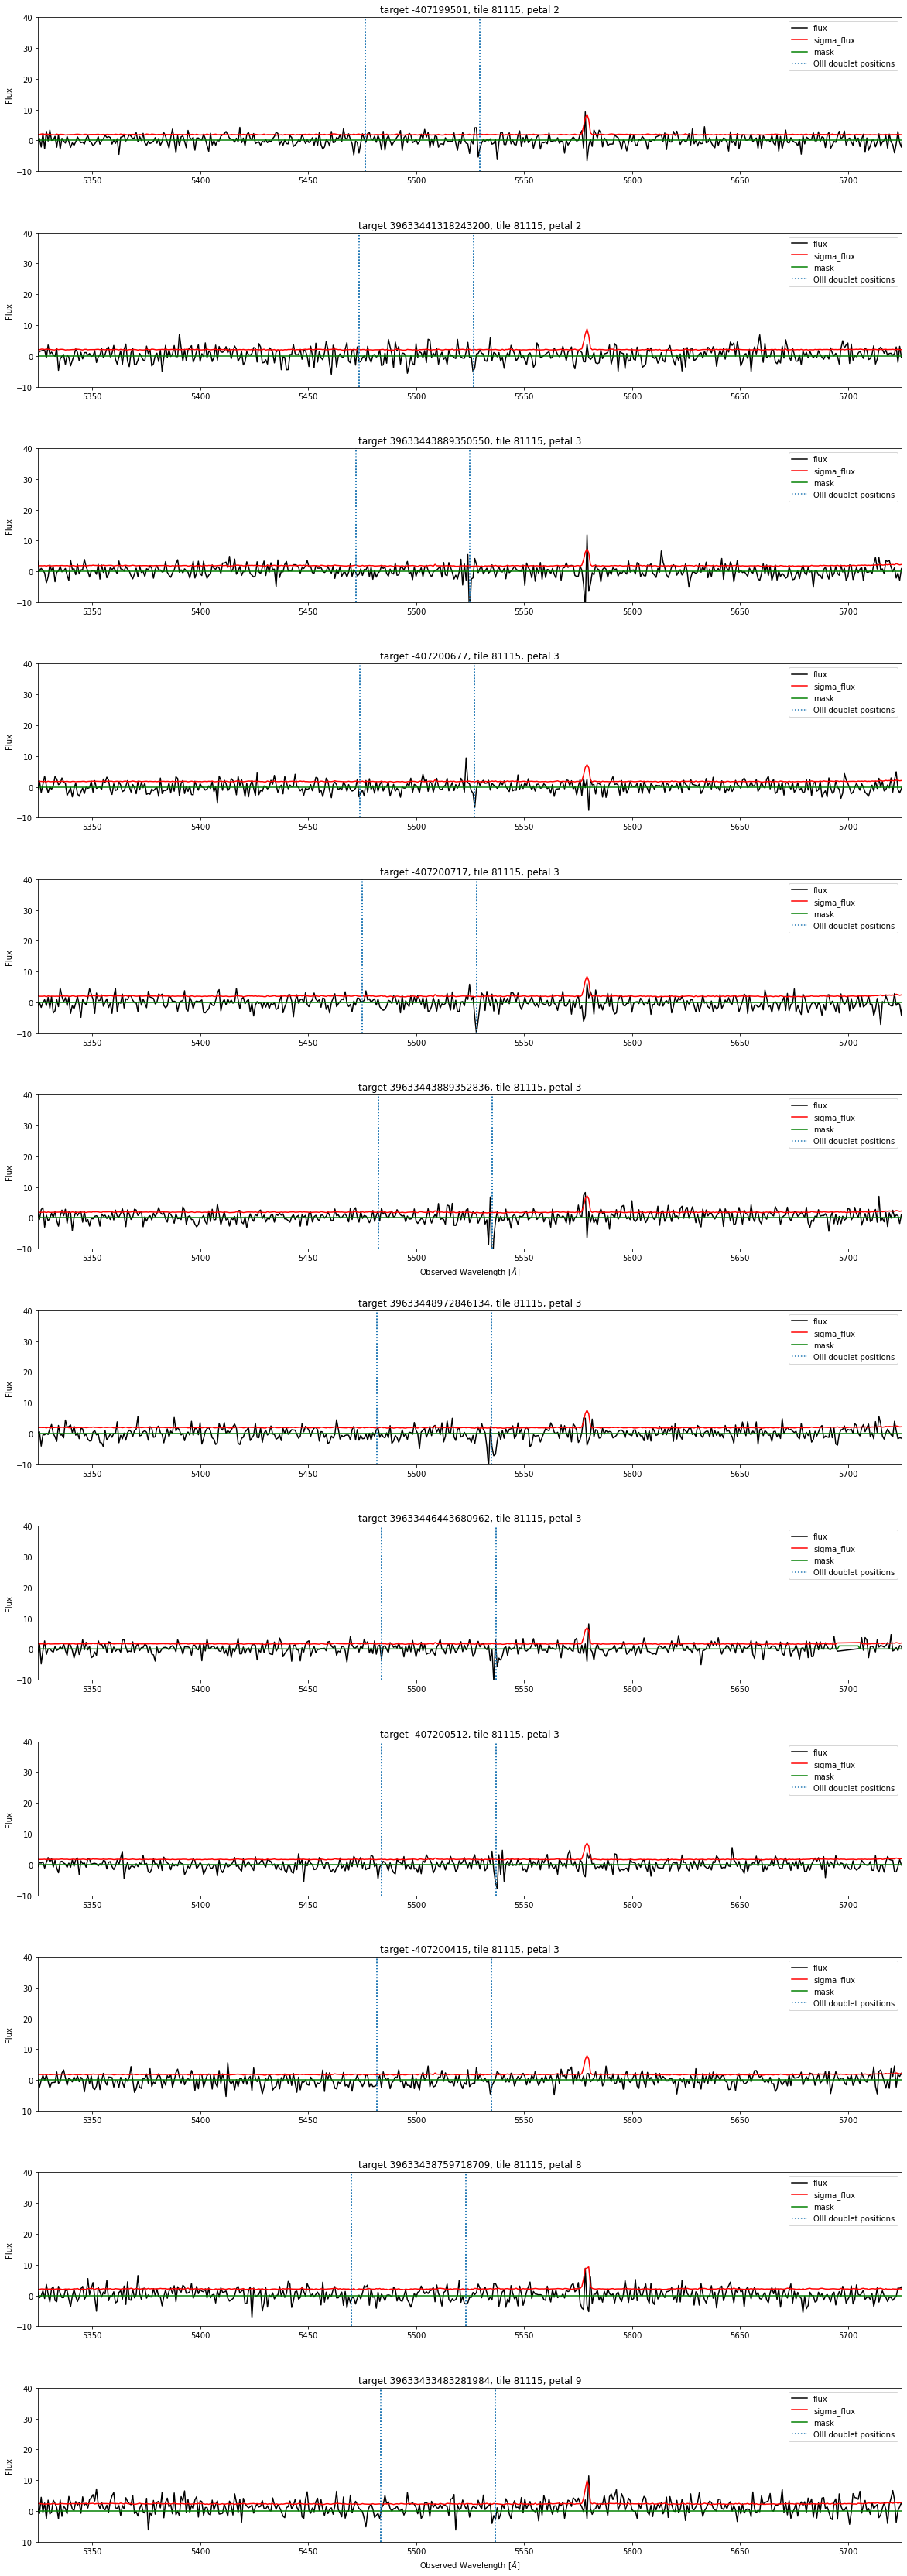

In [42]:
fig,ax_all=plt.subplots(len(outdict),figsize=(20,5*len(outdict)))
plt.subplots_adjust(hspace=0.4)
cou=0
for ax,(tid, tdict) in zip(ax_all,outdict.items()):
    cou=cou+1
    for j,(w,f,i,m) in enumerate(zip(tdict['wave'],tdict['flux'],tdict['ivar'],tdict['mask'])):
        ax.plot(w[m==0],f[m==0],color='k',label='flux' if j==0 else '')
        ax.plot(w[m==0],i[m==0]**(-0.5),color='r',label='sigma_flux' if j==0 else '')
        ax.plot(w,m,color='g',label='mask' if j==0 else '')
        ax.set_title('target {}, tile {}, petal {}'.format(tid,tdict['tile'],tdict['petal']))
        ax.axvline(4960.295*(1+tdict['redshift']),ls=':',label='OIII doublet positions' if j==0 else '')
        ax.axvline(5008.239*(1+tdict['redshift']),ls=':')
        ax.set_ylim(-10,40)
        ax.set_xlim(5000*1.105-200,5000*1.105+200)
        ax.legend()
        ax.set_ylabel('Flux')
    if cou%6==0:    
     ax_all[cou-1].set_xlabel(r'Observed Wavelength [$\AA$]')
     print(cou)
plt.savefig('spectra.png')        
#1.105 is the 1+z for those objects, please read those from the respective RRFN
#5000 is the ~ wavelength of the OIII doublet, needs to be adapted for OII

In [ ]:
fig,ax_all=plt.subplots(len(outdict),figsize=(20,5*len(outdict)))
for ax,(tid, tdict) in zip(ax_all,outdict.items()):
    for j,(w,f,i,m) in enumerate(zip(tdict['wave'],tdict['flux'],tdict['ivar'],tdict['mask'])):
        ax.plot(w[m==0],f[m==0],color='k',label='flux' if j==0 else '')
        ax.plot(w[m==0],i[m==0]**(-0.5),color='r',label='sigma_flux' if j==0 else '')
        ax.plot(w,m,color='g',label='mask' if j==0 else '')
        ax.set_title(tid,'')
        ax.axvline(4960.295*(1+tdict['redshift']),ls=':',label='OIII doublet positions' if j==0 else '')
        ax.axvline(5008.239*(1+tdict['redshift']),ls=':')
        ax.set_ylim(-10,100)
        ax.set_xlim(5000*1.105-200,5000*1.105+200)
        ax.legend()
        ax.set_ylabel('Flux')
ax_all[-1].set_xlabel(r'Observed Wavelength [$\AA$]')
        
plt.savefig('spectra.png')        
#1.105 is the 1+z for those objects, please read those from the respective RRFN
#5000 is the ~ wavelength of the OIII doublet, needs to be adapted for OII

In [37]:
catalog

TARGETID,Z,ZWARN,SPECTYPE,DELTACHI2,TARGET_RA,TARGET_DEC,OBJTYPE,OII_FLUX,OII_FLUX_IVAR,OII_SIGMA,OII_SIGMA_IVAR,OII_CONT,OII_CONT_IVAR,OII_SHARE,OII_SHARE_IVAR,OII_EW,OII_EW_IVAR,OII_CHI2,OII_NDOF,HDELTA_FLUX,HDELTA_FLUX_IVAR,HDELTA_SIGMA,HDELTA_SIGMA_IVAR,HDELTA_CONT,HDELTA_CONT_IVAR,HDELTA_SHARE,HDELTA_SHARE_IVAR,HDELTA_EW,HDELTA_EW_IVAR,HDELTA_CHI2,HDELTA_NDOF,HGAMMA_FLUX,HGAMMA_FLUX_IVAR,HGAMMA_SIGMA,HGAMMA_SIGMA_IVAR,HGAMMA_CONT,HGAMMA_CONT_IVAR,HGAMMA_SHARE,HGAMMA_SHARE_IVAR,HGAMMA_EW,HGAMMA_EW_IVAR,HGAMMA_CHI2,HGAMMA_NDOF,HBETA_FLUX,HBETA_FLUX_IVAR,HBETA_SIGMA,HBETA_SIGMA_IVAR,HBETA_CONT,HBETA_CONT_IVAR,HBETA_SHARE,HBETA_SHARE_IVAR,HBETA_EW,HBETA_EW_IVAR,HBETA_CHI2,HBETA_NDOF,OIII_FLUX,OIII_FLUX_IVAR,OIII_SIGMA,OIII_SIGMA_IVAR,OIII_CONT,OIII_CONT_IVAR,OIII_SHARE,OIII_SHARE_IVAR,OIII_EW,OIII_EW_IVAR,OIII_CHI2,OIII_NDOF,HALPHA_FLUX,HALPHA_FLUX_IVAR,HALPHA_SIGMA,HALPHA_SIGMA_IVAR,HALPHA_CONT,HALPHA_CONT_IVAR,HALPHA_SHARE,HALPHA_SHARE_IVAR,HALPHA_EW,HALPHA_EW_IVAR,HALPHA_CHI2,HALPHA_NDOF,RRFN,FN,COADDFN
int64,float64,int64,bytes6,float64,float64,float64,bytes3,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,str107,str106,str105
39633441360187818,0.3035839561597673,4,GALAXY,1.457692451775074,290.570276799202,64.64679128789841,TGT,16.497446,0.0038250533,2.2499554,0.11168121,0.72302234,0.018851561,1.0,0.8405737,29.744318,0.0011766923,27584.559,131,-31.67389,0.004151289,2.8953316,0.36338165,1.1105373,0.042701453,--,--,-37.179817,0.003012806,13305.247,128,--,--,--,--,0.05244394,0.039256748,--,--,--,--,--,-99,-6.9033523,0.011385004,0.19388293,23.031153,0.70813155,0.19754988,--,--,-12.708232,0.0033595648,494.14984,128,44.525513,0.0028244609,9.798765,0.044436,0.29397702,0.22182585,0.744,inf,197.43973,0.00014364296,132.17786,207,-3.9051175,0.1755026,1.2489463,1.2941557,0.3115492,0.61586964,--,--,-16.33979,0.01002441,4.486829,129,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/redrock-8-81115-thru20210513.fits,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/emline-8-81115-thru20210513.fits,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/coadd-8-81115-thru20210513.fits
39633438763911726,0.24717162880800303,4,GALAXY,2.4096115827560425,290.45517702837344,64.56302090356073,TGT,32.214172,0.008056373,0.6342255,19.099382,0.659958,0.030225534,0.8071839,33.516518,60.877506,0.0022558998,18486.736,126,3.8424747,0.015797505,1.5152338,0.07313409,-0.13219014,0.08573077,--,--,-36.252518,0.00017747378,1340.8123,123,20.068796,0.005996726,3.4418721,0.15302971,0.3345354,0.09553717,--,--,74.817894,0.0004314653,1547.8444,122,--,--,--,--,-0.017358145,0.3366901,--,--,--,--,--,-99,23.919252,0.006596245,7.937277,0.045896888,-0.18320695,0.3749913,0.744,inf,-162.82906,0.00014234039,20.315022,198,-17.813969,0.030888,10.0,0.07055722,0.6887913,1.2259614,--,--,-32.255165,0.009421338,0.6500776,120,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/redrock-8-81115-thru20210513.fits,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/emline-8-81115-thru20210513.fits,/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/81115/20210513/coadd-8-81115-thru20210513.fits
39633441364377647,0.7507999894808937,4,GALAXY,0.6701565459370613,290.6802058263093,64.72016113001624,TGT,10.38238,0.04974444,0.820706,5.9777174,0.029986745,0.30865204,0.5383993,30.38479,606.1835,1.4592513e-05,31.020422,178,6.7608404,0.0388857,2.4083006,0.22090913,0.3344146,